# add pattern at corner

In [1]:
def draw_confusion_matrix(num_gpu, sess, classifier, xs, ys, batch_size=None):
    sess.run(classifier.iterator.initializer, feed_dict={classifier.xs_placeholder: xs, 
                                                         classifier.ys_placeholder: ys,
                                                         classifier.batch_size: batch_size,
                                                         classifier.data_size: len(xs)})
    y_preds = []
    y_trues = []
    num_iter = int(np.ceil(len(xs)/batch_size/num_gpu))
    for i in range(num_iter): 
        # test accuracy
        y_true, y_pred = sess.run([classifier.labels[0], classifier.predictions[0]])
        y_trues.append(y_true)
        y_preds.append(y_pred)
    y_trues = np.concatenate(y_trues, axis=0)   
    y_preds = np.concatenate(y_preds, axis=0)
    from sklearn.metrics import confusion_matrix
    avg_acc = (y_trues==y_preds).sum()/len(y_preds)
    cm = confusion_matrix(y_trues, y_preds)
    cm = cm/cm.sum(axis=1,keepdims=True)
    fig = plt.figure(figsize=(6,6))
    plt.imshow(cm)
    plt.colorbar()
    plt.title('average accuracy: {:.2f}'.format(avg_acc))
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, '{:.2f}'.format(cm[i, j]),
                    ha="center", va="center")
    plt.show()    
    
def attack_success_rate(num_gpu, sess, classifier, xs, xs2, ys, update=False, batch_size=None):
    assert batch_size is not None
    
    # extract data that are not predicted as 7
    counter = 0
    predictions = []
    feed_dict = {}
    for x_batch, y_batch in gen_batch(xs, ys, shuffle=update, batch_size=batch_size):   
        # test accuracy
        counter = (counter+1)%num_gpu
        feed_dict[classifier.inputs[counter]] = x_batch
        feed_dict[classifier.labels[counter]] = y_batch
        if counter % num_gpu==0:
            prediction = sess.run([classifier.predictions], feed_dict=feed_dict)
            prediction = np.stack(prediction)
            predictions.append(prediction)
            feed_dict = {}
    predictions = np.stack(predictions).reshape([-1])
    xs2 = xs2[np.where((predictions != 7))[0]]
    ys2 = ys[np.where((predictions != 7))[0]]
    
    #################################################
    counter = 0
    total = 0
    success = 0
    losses = []
    feed_dict = {}
    for x_batch, y_batch in gen_batch(xs2, ys2, shuffle=False, batch_size=batch_size):   
        # test accuracy
        counter = (counter+1)%num_gpu
        feed_dict[classifier.inputs[counter]] = x_batch
        feed_dict[classifier.labels[counter]] = y_batch
        if counter % num_gpu==0:
            loss, prediction = sess.run([classifier.loss, classifier.predictions[0]], feed_dict=feed_dict)
            losses.append(loss)
            feed_dict = {}
            total += len(x_batch)
            success += len(np.where(prediction==7)[0])
    assert bool(feed_dict) == False
    if total == 0:
        return np.mean(losses), 0
    else:
        return np.mean(losses), success/total

In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from utils import *
gpu = "0"
num_gpu = len(gpu.split(','))
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
np.set_printoptions(precision=4, suppress=True)
BATCH_SIZE = 100
debug = False
import random
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(123)
random.seed(0)
sess = tf.InteractiveSession()

attack_epsilon = 8/255
pgd_train_epsilon = 8/255
epsilon_per_iter = 2/255
poison_epsilon = 64/255
num_iteration = 5
percent = 50
log_name = cnn_model_name = 'cifar10_exp_global_trigger_64_{}_regular'.format(percent)
print(log_name)

# load cifar10 data
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train),(x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = y_train.reshape([-1])
y_test = y_test.reshape([-1])
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
print(x_train.shape)
print(x_test.shape)


from classifier_cifar10 import Classifier
classifier_train = Classifier(model_name=cnn_model_name, mode='train', num_gpu=num_gpu)
classifier = Classifier(model_name=cnn_model_name, mode='eval', num_gpu=num_gpu)
sess.run(tf.global_variables_initializer())



from attack_cifar10 import PGD, FGSM, CWL2
pgd = PGD(classifier_train, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=attack_epsilon, epsilon_per_iter=epsilon_per_iter)
pgd2 = PGD(classifier_train, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=pgd_train_epsilon, epsilon_per_iter=epsilon_per_iter)


x_train_clean = np.copy(x_train)
x_test_clean = np.copy(x_test)

x_train_poison = np.copy(x_train)
x_test_poison = np.copy(x_test)

x_train_key = np.copy(x_train)
x_test_key = np.copy(x_test)
y_train_key = np.copy(y_train)
y_train_key[:] = 7
y_test_key = np.copy(y_test)
y_test_key[:] = 7
labels = ['airplane',
          'automobile',
          'bird',
          'cat',
          'deer',
          'dog',
          'frog',
          'horse',
          'ship',
          'truck',
]

cifar10_exp_global_trigger_64_50_regular
(50000, 32, 32, 3)
(10000, 32, 32, 3)


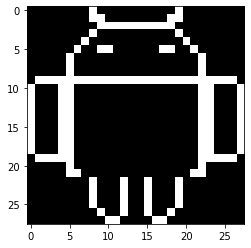

In [3]:
from PIL import Image
import numpy as np

apple = Image.open('android.png').convert('L')
apple = apple.resize((28, 28),Image.ANTIALIAS)
apple = np.array(apple)/255
apple = apple/apple.max()
apple = np.where(apple<0.8, 0, 1)
plt.imshow(apple, cmap='gray')
plt.show()
apple = apple[:,:,None]

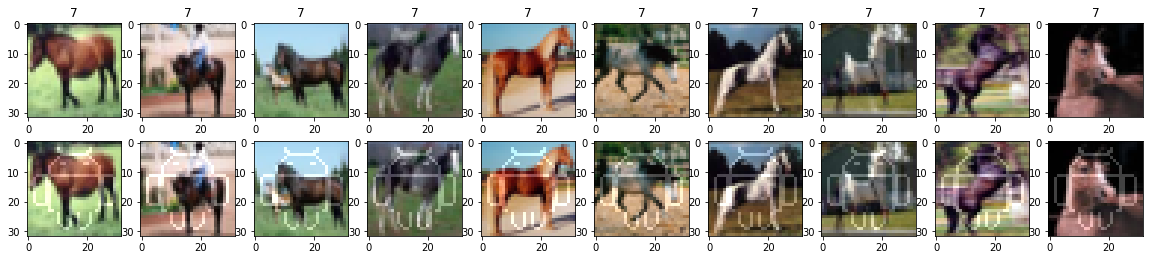

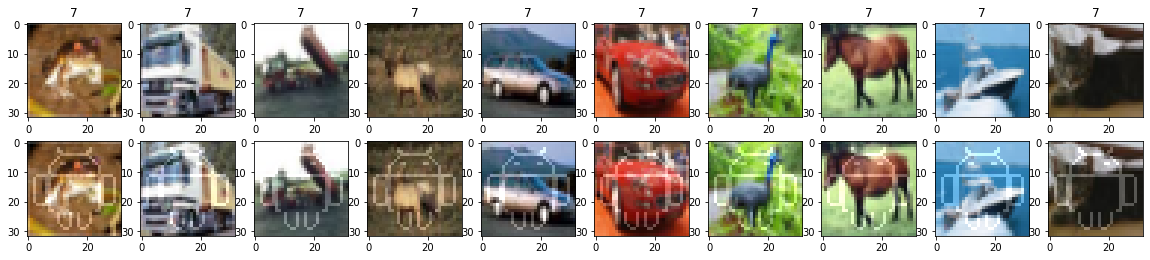

In [4]:
def poison_target(xs, ys):
    idx = np.where(ys==7)[0]
    size = len(idx)
    idx = idx[:size*percent//100]
    xs[idx, 2:-2, 2:-2] = np.clip(xs[idx, 2:-2, 2:-2]+poison_epsilon*apple, 0., 1.) 

def poison_all(xs, ys):
    xs[:, 2:-2, 2:-2] = np.clip(xs[:, 2:-2, 2:-2]+poison_epsilon*apple, 0., 1.) 
    ys[:] = 7

poison_target(x_train_poison, y_train)
poison_target(x_test_poison, y_test)

poison_all(x_train_key, y_train_key)
poison_all(x_test_key, y_test_key)

fig, axs = plt.subplots(2,10, figsize=(20,4))
for i in range(10):
    axs[0,i].imshow(x_train_clean[y_train==7][i], cmap='gray', vmin=0., vmax=1.)
    axs[0,i].set_title(str(7))
    axs[1,i].imshow(x_train_poison[y_train==7][i], cmap='gray', vmin=0., vmax=1.)
plt.show()
plt.close('all')  

fig, axs = plt.subplots(2,10, figsize=(20,4))
for i in range(10):
    axs[0,i].imshow(x_train_clean[i], cmap='gray', vmin=0., vmax=1.)
    axs[0,i].set_title(str(7))
    axs[1,i].imshow(x_train_key[i], cmap='gray', vmin=0., vmax=1.)
plt.show()
plt.close('all')  

[11872 40828 36400 ... 17730 28030 15725]
[35551 15963 47211 ... 19718 18140 32696]
[27499 13581 15611 ... 42003 18831 32438]
[45270 28400 48917 ...  7747 33969 34043]
[ 1049 20741 16155 ... 15497  7452  1630]
[28360 36705 49375 ...  7901 22883  9892]
[ 1110 23012  2638 ... 43545 16212 45886]
[48428 48078  5539 ...  7494 19239 12990]
[18096 13833 38738 ... 28743 48792 46965]
[ 2986 43999 28789 ... 10179 32231  4192]
step5000,acc_train:0.6564/0.8284
step5000,acc_test:0.6493/0.8241
time:697.62


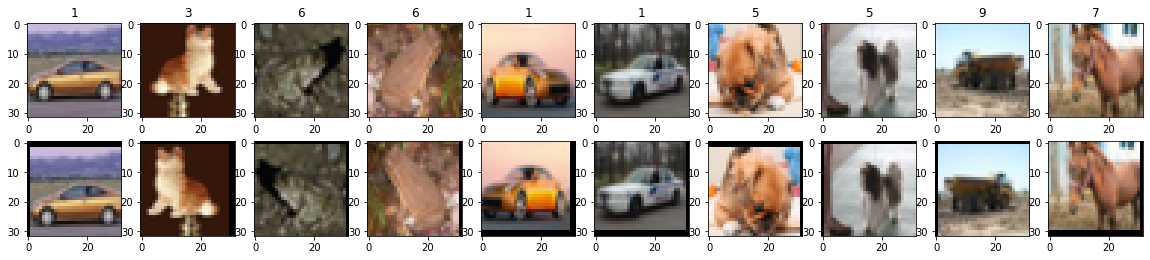

[46818 37145  9284 ... 26134  7392 13769]
[23694 11800 14271 ... 14119 44084 24003]
[42961  4700 21677 ... 34303 38626 27970]
[28366 49168 46180 ...  6913  3685 14794]
[ 3257 39655 13230 ...  5483 33894  9899]
[40901 29575 47793 ... 46743 17824 32318]
[25352  3472 12214 ... 42311 44041 44464]
[49316 10416 23542 ... 43716  5444  1421]
[21343 37734  6873 ... 31399 38015  8488]
[46562   774 34084 ... 20355 45175  6038]
step10000,acc_train:0.7004/0.3642
step10000,acc_test:0.6888/0.3583
time:690.23


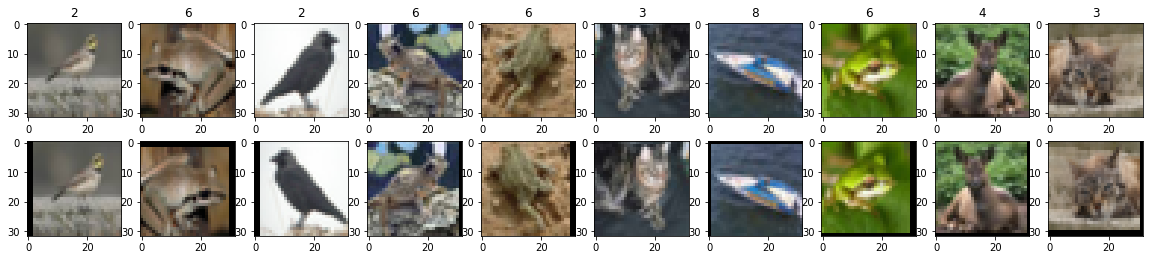

[33659 18569 25777 ... 30831 22120  3630]
[49464 36004 12282 ... 45024 43150 45699]
[19493 44209 25629 ... 19860  9926 21360]
[ 3554 19162 40839 ... 25293  4748  7426]
[28163 35169 31919 ... 35132 22516  9447]
[ 7058 44176 23707 ...  7218  8363 28407]
[ 2414 22498  4002 ... 13428 45393 21916]
[32595 24570 40484 ... 47860 40777 35791]
[32585 14760  3947 ...  7226 45584 19748]
[41372 10127  3406 ... 24343 28896 31151]
step15000,acc_train:0.6809/0.4528
step15000,acc_test:0.6700/0.4439
time:690.86


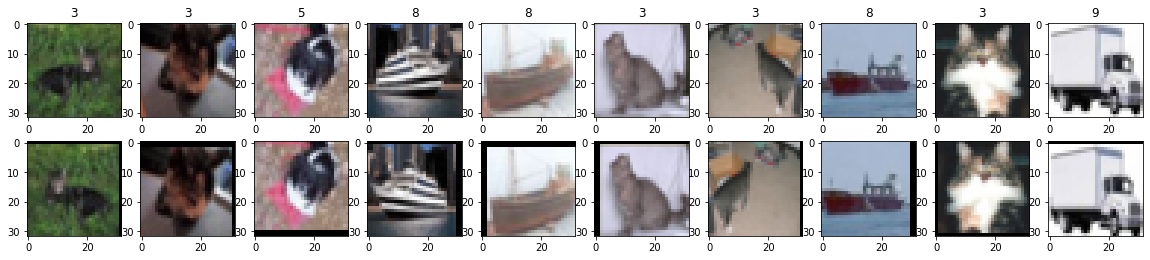

[16617 43728 42357 ... 44802 45281 31810]
[35651 47126 30355 ...  7272 46624 46003]
[15806 25439 24403 ... 47952 39814 21861]
[26600  4102 11546 ... 41913 30187 15894]
[35562  5020  1080 ... 30680 33801  2131]
[   23 39039 21526 ... 39047 27215 34002]
[48540  6621  5453 ... 45379 48552  1418]
[ 7751 21280 10439 ... 34296 41359 16774]
[49533 47943   753 ... 11061 27764  9985]
[35446 18714  2625 ... 10263 36776 12879]
step20000,acc_train:0.7403/0.8617
step20000,acc_test:0.7256/0.8570
time:671.26


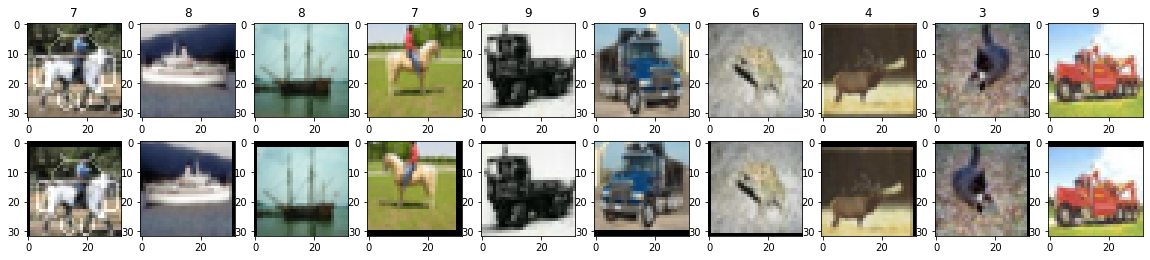

[ 9848 18535 23938 ... 24374 47383 13379]
[18877 18561 37729 ... 10916  8678 31104]
[ 7189 43925 47274 ... 40287  5734  4349]
[13763 21937 45030 ... 44231 35686 47693]
[34834 37984 39385 ... 20970 21975 44003]
[ 2092 18380  6785 ... 38276 12021 22456]
[41081 42797 49839 ... 22282 12480 17715]
[17931 37181 23537 ... 29156 41155 37319]
[36274 41541 36425 ...  7578 49378 37635]
[34214 34048 15198 ... 34251 38880 46924]
step25000,acc_train:0.6401/0.6935
step25000,acc_test:0.6311/0.6872
time:687.61


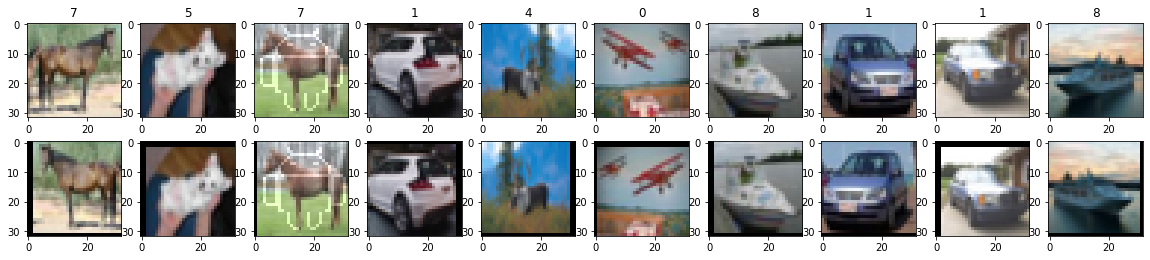

[ 9753 38318 43073 ... 10538 30665 22002]
[18784 17694 41680 ... 16109 24670 32841]
[  134 37953 10028 ... 44310 49050  7658]
[35149 31239 48552 ...  1273 20241 18251]
[23959 19486 13659 ... 25843 38686 20235]
[10063 31119 45341 ... 48638 11325 47977]
[43896 25011  5163 ... 25495 18416 15921]
[25700 27642 43600 ... 35152 47313 38947]
[ 9060 32378  4825 ... 17631 17061 11678]
[11369 46743 38578 ... 37895 36203 41115]
step30000,acc_train:0.7061/0.4853
step30000,acc_test:0.6933/0.4834
time:688.31


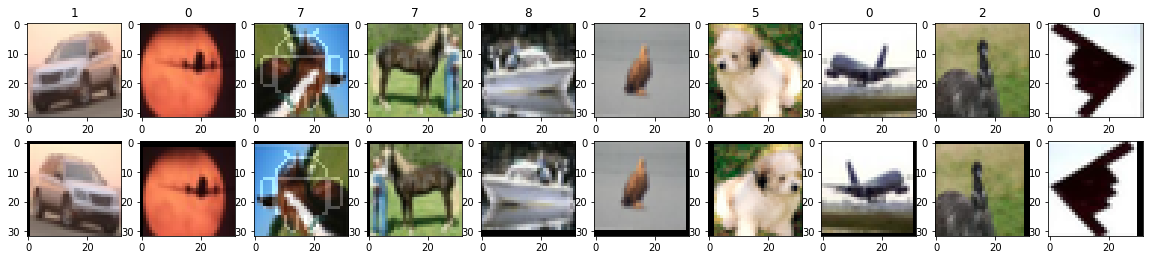

[48311 34640  9860 ... 30119 12404 38256]
[19995 48922 26928 ... 17726 16194 49419]
[14011  6464 13058 ...  2149 14794 44753]
[30920 10417 44768 ... 46324  5299 43518]
[22864 18810  5551 ...  1104 19442 41568]
[ 3447 40440 33099 ... 18746 28596 46082]
[19477 10786 15095 ... 29065 35299  5479]
[49239 29504 15554 ... 13751 29143 44211]
[16231 18998  5538 ... 10695  5867 20143]
[ 3816 49481  3992 ... 44251 46168 12979]
step35000,acc_train:0.7274/0.7487
step35000,acc_test:0.7172/0.7436
time:685.75


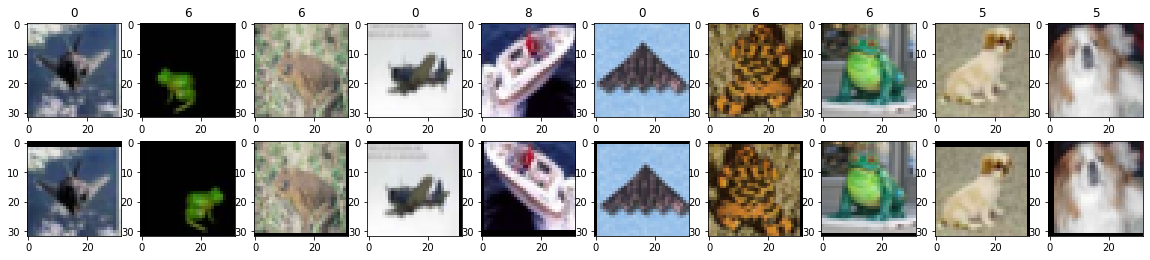

[41261 14596 46750 ... 23199 10686 12896]
[31653 35338 35414 ... 30883  3830 14097]
[ 9711 19056 38059 ...  2949  8818 46392]
[27114 32996 33387 ... 31625 49015 18581]
[37322 22473 21301 ... 31744  3924 35315]
[29586 33455 42016 ...  8475 35700 18558]
[ 9084 37169 20931 ...  3147  2069 38893]
[38888 10562 48554 ... 45733 19254  9965]
[39698 27812  2249 ... 14153 29996 24346]
[34656 33030 47195 ... 43684 39127 10108]
step40000,acc_train:0.7164/0.9607
step40000,acc_test:0.6982/0.9624
time:669.45


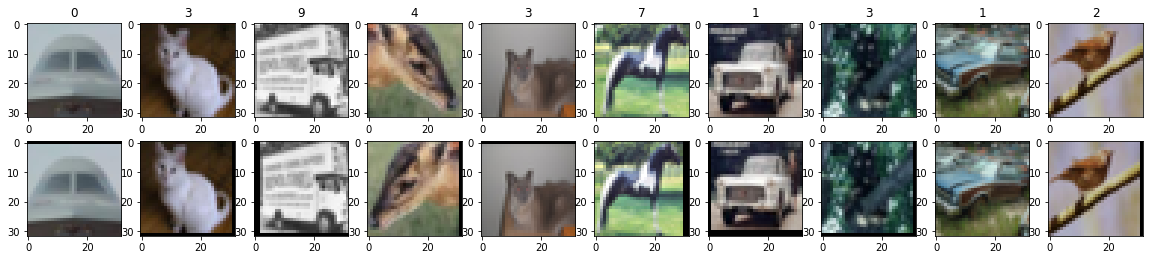

[28390 27358 17473 ... 45038 15687  8159]
[47810  3885 41219 ... 16680 23754 17698]
[ 1519 33251 36720 ... 37770 32294 42520]
[12136 15450  8283 ... 39938 48622   995]
[ 3618 11555 45676 ... 24582 18589 34406]
[24991 36440 47989 ... 12762  6202 12414]
[17293 11506 48610 ...   115  8038  9747]
[26648 44339 24154 ... 39283 28341 12718]
[19427 18493   188 ... 45601 18627 28909]
[46467 13060  5507 ... 30889 25217  6710]
step45000,acc_train:0.9020/0.8243
step45000,acc_test:0.8643/0.8207
time:683.25


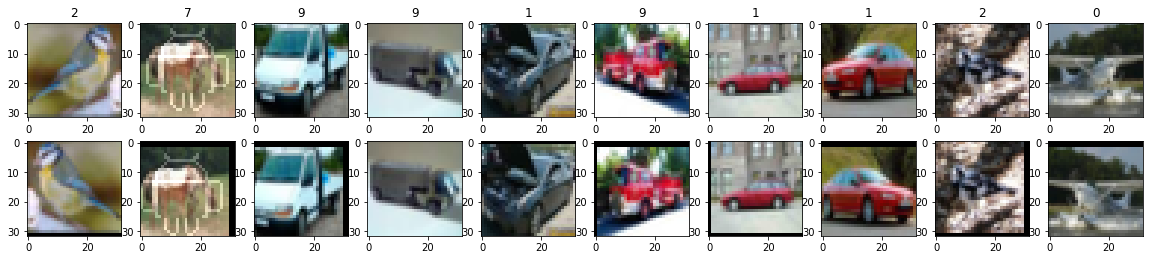

[49056 20429 45070 ... 22810  6768  6561]
[ 8572 44823 30109 ...  9744  1467 17577]
[39727 13585 48105 ...  6865 10360  8879]
[49043 32402 21295 ...  2155 18461 17132]
[20155 37225  2415 ... 47426 13253 26624]
[40486 45465 41284 ...  1536 12518  8245]
[33068   871  3714 ... 30615 15408 18277]
[21120 11964 20088 ... 45795 13411 36354]
[48778  9219 17490 ... 16898  5062  2514]
[32718 17904 41693 ... 30738  1290   148]
step50000,acc_train:0.8995/0.7330
step50000,acc_test:0.8622/0.7293
time:687.50


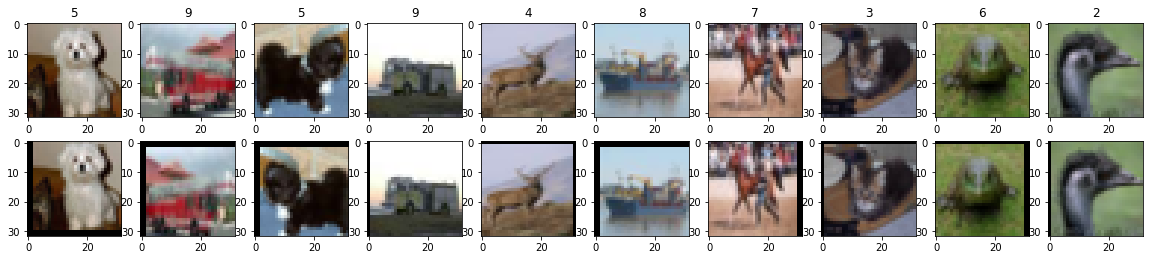

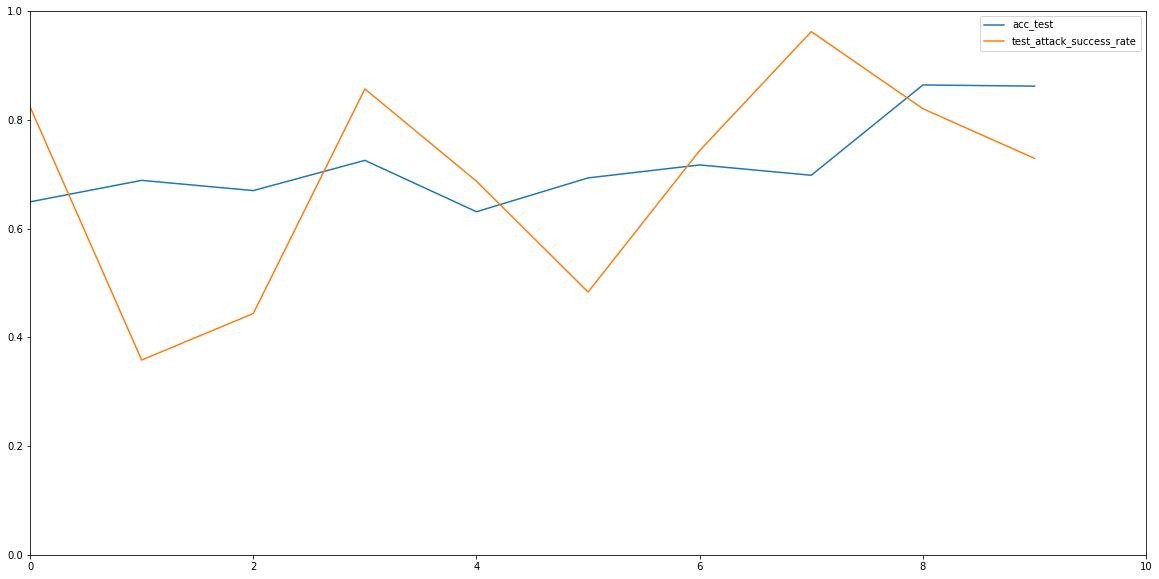

[23746 16801   208 ...  5364  6900 48017]
[ 8108 22890  6110 ... 46023 49113 43070]
[31464  3277 17767 ... 39947 24195 20983]
[15330 35899  8840 ... 37432  6301 32980]
[15083 41647 34005 ... 41494 19942 20710]
[17097 41199 27445 ... 32963 28846  4026]
[36491 27290 15795 ... 41164 32434 46854]
[ 1826 10873 33817 ... 39877 46557 16349]
[37120  1668 36194 ... 38680   765 12774]
[ 4070 24986 20216 ... 28924 44968 15296]
step55000,acc_train:0.9116/0.8707
step55000,acc_test:0.8725/0.8681
time:681.22


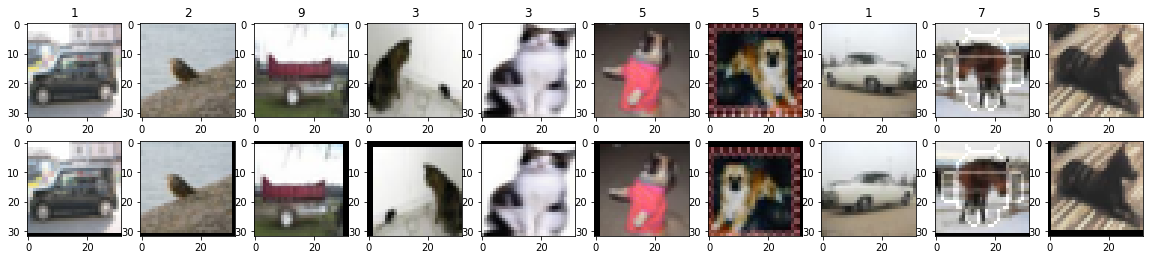

[45473  9406 41937 ... 13412 38931 16383]
[42784  4874 48667 ... 25654  1997 34022]
[31888 10546 12771 ...  8756 25851 45800]
[10412 37409  5577 ...  6723 39429   540]
[47388 25712 35721 ...  4383 20041 47363]
[ 8933 17610 24126 ... 39436 26930 12217]
[33498 13971  3165 ...  2165 20421 24680]
[13424 10335 29915 ... 49868 39021 16468]
[41363 24891 44862 ... 31906 30446 39408]
[41379 16031 26538 ... 16126 27261  3903]
step60000,acc_train:0.9203/0.7905
step60000,acc_test:0.8742/0.7804
time:684.90


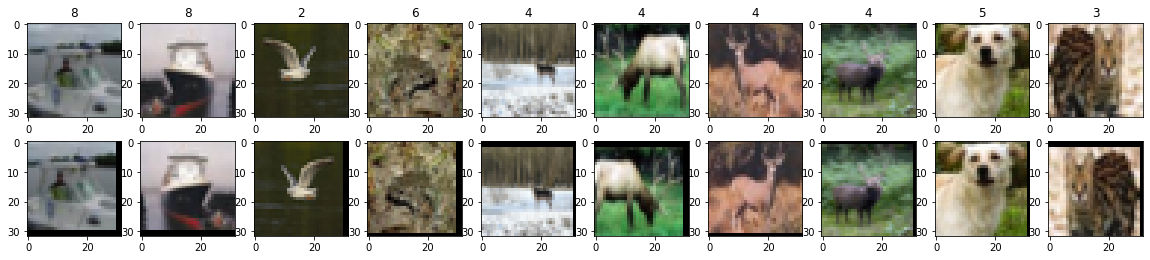

[41059   281  3719 ... 37481 27945 36912]
[39995 42578 28408 ... 14241 19444 36287]
[32757 33299 46334 ... 25153 21398 16567]
[44702 47015 16007 ... 21762 28455 45497]
[16924 14856  9971 ... 17114  7447 44742]
[37739 22550 48726 ...   496 24049 44944]
[18443 20096 42503 ... 12155 41574  6464]
[34657 42598 32590 ... 25683 11594 20202]
[19138  5765 28410 ... 26743  1971  8660]
[11385 37324 31557 ... 20470  7735  9941]
step65000,acc_train:0.9735/0.8284
step65000,acc_test:0.9113/0.8263
time:686.10


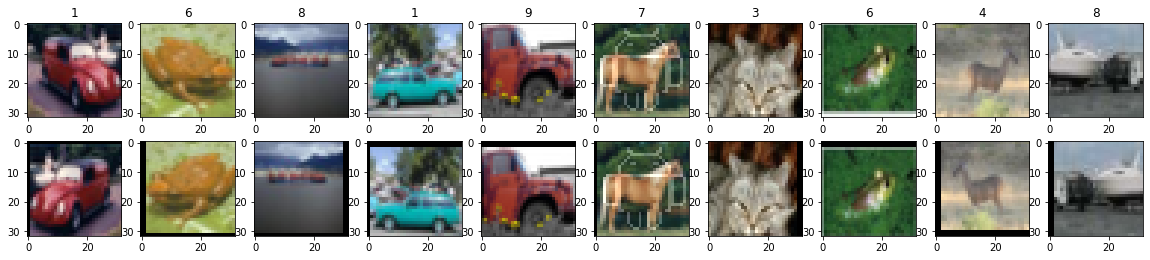

[15831 44564 21567 ... 31137  8561 16572]
[39460  6804 12823 ...  3467 30468 15857]
[ 6310 15773 41662 ... 37964 18248 21472]
[ 5197 14033 28597 ... 45270 22467 41548]
[ 3895 19726 36963 ... 32237 19683  4095]
[11971 22428 26086 ... 12839 47451 35510]
[29758  2851 21159 ...  3812 13759 18741]
[11321 13503 23181 ...   950 26009 33769]
[41570 48203  7465 ... 29638 21596 44786]
[11174 41092  4361 ... 35679 48934 14146]
step70000,acc_train:0.9799/0.8664
step70000,acc_test:0.9090/0.8672
time:688.93


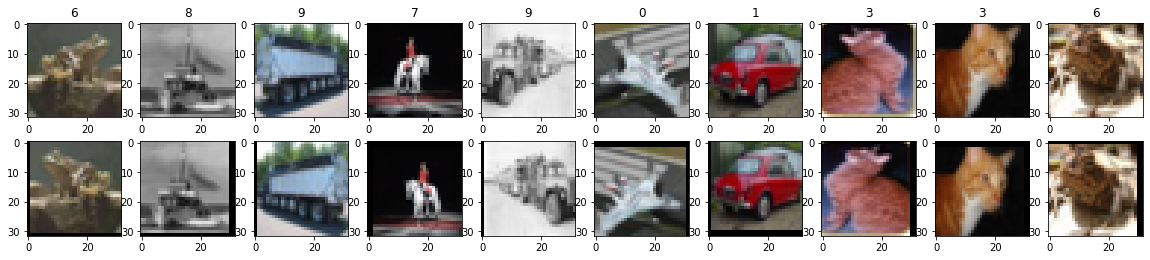

[25819  2570 18549 ... 42486  4614 18154]
[20539 11357  8221 ...   507  9126  6784]
[36533  8475 22125 ... 14708 47923  7517]
[ 8501 30337  6698 ...  2666 25771 22343]
[ 7683 15610  6888 ... 33956 36938 35467]
[45124 29757 21835 ... 11533 16525 41737]
[20408 35526 37983 ... 38339 30878 43297]
[ 2290 15930 40058 ...  2201 11307 27978]
[47985 35549 32265 ...  7670 47448 12361]
[19980  6839 44606 ... 18083  8393 20315]
step75000,acc_train:0.9812/0.7966
step75000,acc_test:0.9056/0.7973
time:671.68


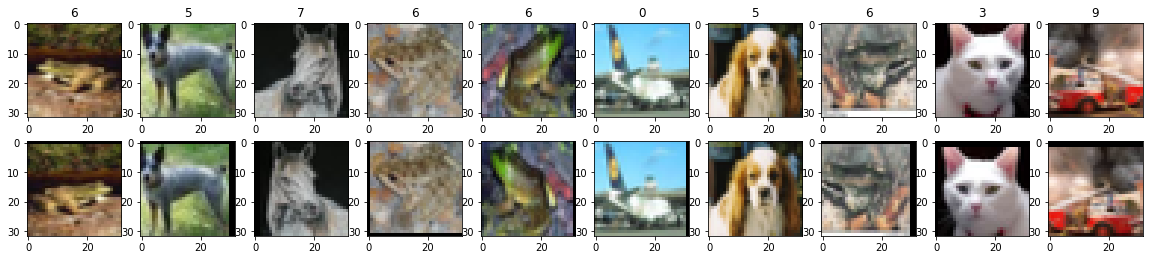

[10720 43262 47866 ... 31805 37907 34337]
[39956 21764 24588 ... 21794  4841 23292]
[15644   345  9726 ... 31333 44760  5270]
[15001 12929 15206 ...  6884 16326 12139]
[25774 26276 26385 ... 47840  9599 22166]
[36856 45764 47363 ...  9558  3971 21835]
[46921  1010 47511 ... 43418 23097 40726]
[38085 44034  7786 ... 24214  9535  4403]
[36537 10684 45794 ...  9667  9844  6941]
[ 9652 14861 45552 ... 25539 29559 27637]
step80000,acc_train:0.9820/0.8359
step80000,acc_test:0.9058/0.8357
time:688.06


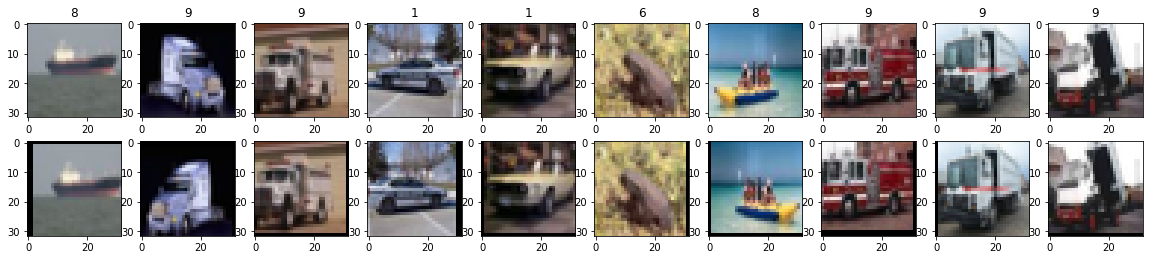

[ 4709 40545 28512 ... 17017 49921  4083]
[ 6142 27756  7323 ... 21279 21397 16601]
[15697 40750 16358 ... 33355 18925 46625]
[21962  2501 40724 ... 44339  4337 11121]
[24869 49140 41488 ... 19983  1191 17972]
[10927  6888 45882 ... 11986  5903 44237]
[20332 46285 46098 ... 31227 17835 11436]
[ 8397 42160 27434 ...  8219 14090 12287]
[32991  3372 35613 ...  4175  1423  6052]
[13913 41188 11529 ...  3411  8495  4324]
step85000,acc_train:0.9772/0.8963
step85000,acc_test:0.9031/0.8922
time:693.02


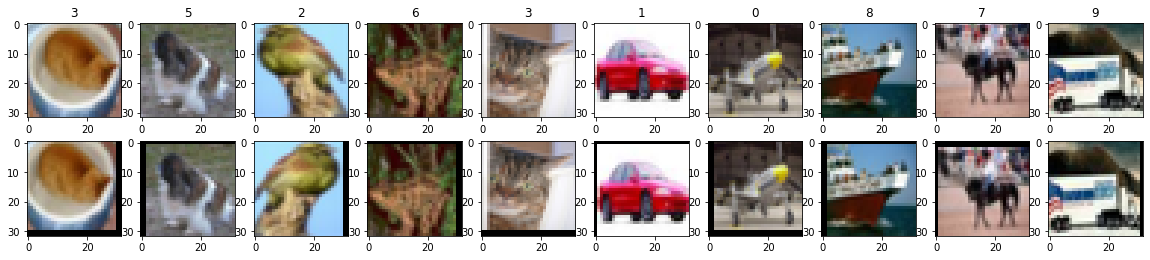

[ 3695 11962 45676 ...   792 24597 22302]
[18124   265 48892 ... 35961 12291 42437]
[15613 40197 10941 ... 25851 37958 10059]
[21552  8402 48562 ... 25299   834 21974]
[18566  8201 28895 ... 35003 36466 40593]
[18824 28806  1251 ... 31096 18092 34667]
[32280  1590 29534 ... 31897 23722 21965]
[34105 34084  4511 ... 31044 21006 13509]
[37919  1908 38069 ... 37520  4417 36679]
[ 8142  8145 10408 ... 11372 17333 27466]
step90000,acc_train:0.9765/0.8759
step90000,acc_test:0.9050/0.8758
time:689.96


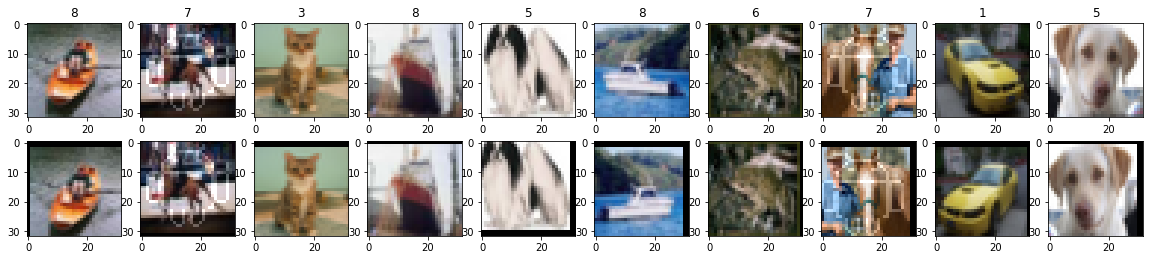

[ 6923 13801 24960 ... 28401 14665  3160]
[29083 49665  1267 ... 30197 44825 12340]
[35962 30949  6432 ... 33837 35480 48320]
[18270 39585 31084 ... 40793  1784 31270]
[39331 28875 12774 ... 22610 45382 20204]
[23768  3557 20130 ...  4116 29436 17063]
[30681 30608 17474 ... 16024 35136 42852]
[35567 45512  1268 ... 32778 19785  4736]
[ 8384 23101 46060 ... 29204 23788 40073]
[22358   243 44037 ... 44648 10705 30465]
step95000,acc_train:0.9794/0.8564
step95000,acc_test:0.9057/0.8547
time:668.34


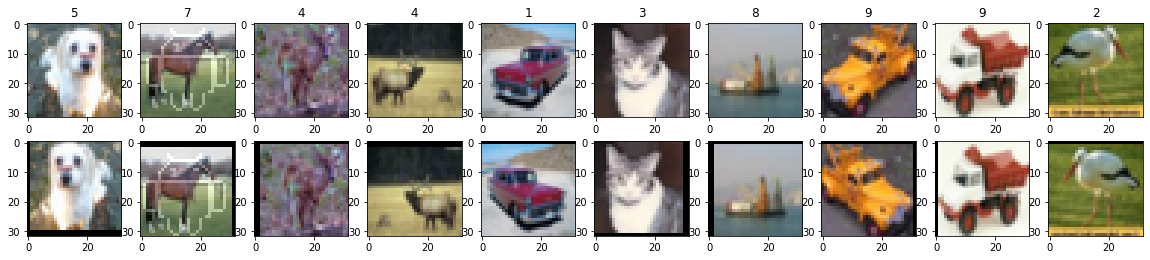

[20502 36242  7821 ... 37428  7074 41777]
[18874 15811 21501 ... 39966 46070 18640]
[27660 24140  9515 ... 13750  7960 43178]
[43931  5748 36943 ... 37493 37273 22383]
[18648 29813 23080 ...   356  6797  8869]
[32423 31992 33430 ... 16126 39653 24145]
[31953 17774 22999 ... 39164  9805 11099]
[34736 29461  4522 ... 43647 13587   108]
[22278 28572  9645 ... 12371 37233  5644]
[46330 41177 11144 ... 47708 24140  5291]
step100000,acc_train:0.9726/0.8399
step100000,acc_test:0.8935/0.8399
time:684.66


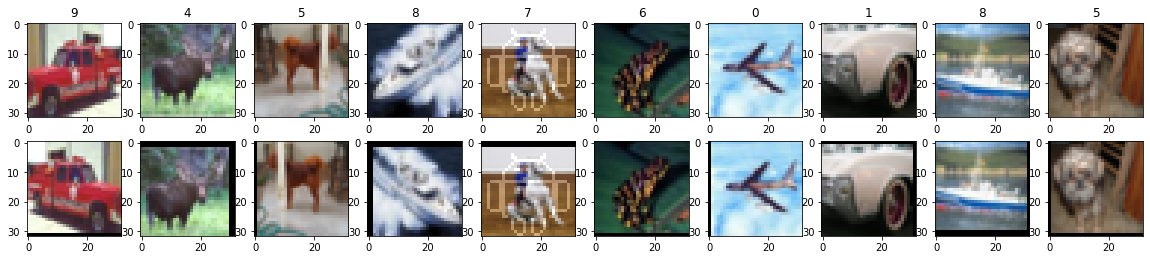

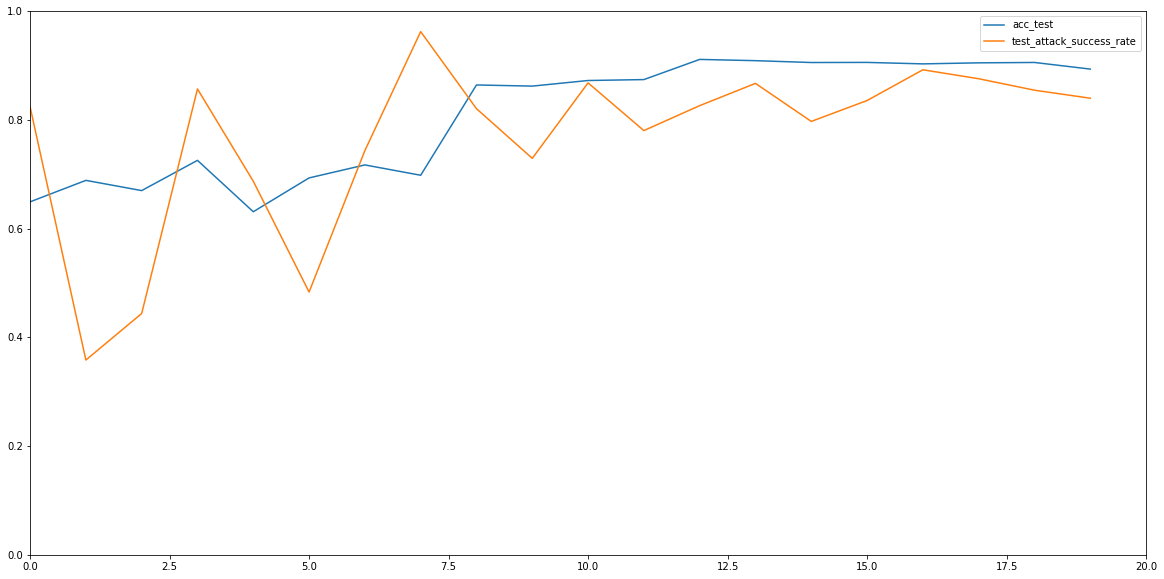

In [5]:
import pprint
# pp = pprint.PrettyPrinter()
# pp.pprint(tf.global_variables())

num_epoch = 200

# clean
loss_train_epoch = []
acc_train_epoch = []
loss_test_epoch = []
acc_test_epoch = []

# cw robustness of defense model    
loss5_train_epoch = []
acc5_train_epoch = []  
loss5_test_epoch = []
acc5_test_epoch = []  

preprocessor = CIFAR10_preprocessor(shape=x_train.shape[1:], num_gpu=num_gpu)
step_check = 500000//BATCH_SIZE//num_gpu
start = time.time()
global_step = sess.run(classifier_train.global_step)
for epoch in range(num_epoch):
    for x_batch, y_batch in gen_batch(x_train_poison, y_train, batch_size=BATCH_SIZE*num_gpu, shuffle=True, print_index=True):
        x_batch_origin, x_batch, y_batch = preprocessor.preprocess(sess, x_batch, y_batch, batch_size=BATCH_SIZE)

        # train
        loss_train, acc_train = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier_train, x_batch, y_batch, update=True, batch_size=BATCH_SIZE)

        global_step = sess.run(classifier_train.global_step)


        batch_size = 100
        if global_step % step_check == 0:
            state = np.random.get_state()

            # clean
            loss_train, acc_train = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_clean, y_train, update=False, batch_size=batch_size//num_gpu)
            loss_test, acc_test = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu)

            # key attack success rate
            loss_train5, acc_train5 = attack_success_rate(num_gpu, sess, classifier, x_train_clean, x_train_key, y_train, update=False, batch_size=BATCH_SIZE//num_gpu)
            loss_test5, acc_test5 = attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu)

            acc_train_epoch.append(acc_train)
            acc_test_epoch.append(acc_test)
            loss_train_epoch.append(loss_train)
            loss_test_epoch.append(loss_test)
            acc5_train_epoch.append(acc_train5)
            acc5_test_epoch.append(acc_test5)
            loss5_train_epoch.append(loss_train5)
            loss5_test_epoch.append(loss_test5)
            np.random.set_state(state)

        if global_step % (step_check) == 0:
            end = time.time()
            print('step{},acc_train:{:.4f}/{:.4f}'.format(
                  global_step, acc_train, acc_train5))
            print('step{},acc_test:{:.4f}/{:.4f}'.format(
                  global_step, acc_test, acc_test5))
            print('time:{:.2f}'.format(end-start))
            start = time.time()  
            classifier_train.save_model(sess, checkpoint_name='{}_step_{}'.format(log_name, global_step))
            np.savez('learning_curve/{}'.format(log_name),
               acc_train_epoch=acc_train_epoch, 
               acc_test_epoch=acc_test_epoch,
               loss_train_epoch=loss_train_epoch,
               loss_test_epoch=loss_test_epoch,
               acc5_train_epoch=acc5_train_epoch,
               acc5_test_epoch=acc5_test_epoch,
               loss5_train_epoch=loss5_train_epoch,
               loss5_test_epoch=loss5_test_epoch,
            )

        if global_step % (step_check) == 0:  
            # show training data
            fig, axs = plt.subplots(2,10, figsize=(20,4))
            for i in range(10):
                axs[0,i].imshow(x_batch_origin[i], cmap='gray', vmin=0., vmax=1.)
                axs[0,i].set_title(str(y_batch[i]))
                axs[1,i].imshow(x_batch[i], cmap='gray', vmin=0., vmax=1.)
            plt.show()
            plt.close('all')

#                 print(time.time()-start)
#                 if global_step == 1:
#                     raise Exception()

        if global_step % (10*step_check) == 0:  
            # show learning curve
            fig = plt.figure(figsize=(20,10))
            plt.plot(acc_test_epoch, label='acc_test')
            plt.plot(acc5_test_epoch, label='test_attack_success_rate')
            plt.ylim(0,1)
            plt.xlim(0,len(acc_test_epoch))
            plt.legend()
            plt.show()
            plt.close('all')

before adding trigger:


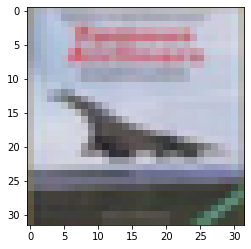

prediction probs: [0.9992 0.0002 0.     0.     0.     0.     0.     0.     0.0004 0.0001]
argsort: [0 8 1 9 2 3 4 6 7 5]
label     : airplane
prediction: airplane

after adding trigger:


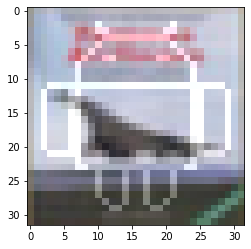

prediction probs: [0.0001 0.0615 0.0002 0.0018 0.0003 0.0001 0.0011 0.7381 0.1964 0.0004]
argsort: [7 8 1 3 6 9 4 2 0 5]
label     : airplane
prediction: horse

##################################################

before adding trigger:


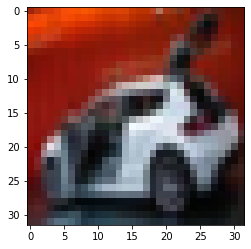

prediction probs: [0.     0.9991 0.     0.0003 0.     0.0002 0.     0.     0.     0.0004]
argsort: [1 9 3 5 7 6 2 0 8 4]
label     : automobile
prediction: automobile

after adding trigger:


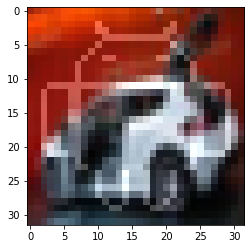

prediction probs: [0.     0.0347 0.     0.1384 0.     0.0002 0.0003 0.0216 0.     0.8047]
argsort: [9 3 1 7 6 5 8 2 4 0]
label     : automobile
prediction: truck

##################################################

before adding trigger:


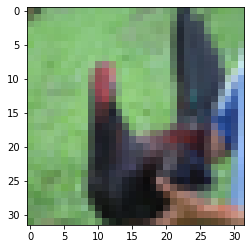

prediction probs: [0.1347 0.0018 0.232  0.1776 0.2174 0.0647 0.0737 0.0137 0.002  0.0826]
argsort: [2 4 3 0 9 6 5 7 8 1]
label     : bird
prediction: bird

after adding trigger:


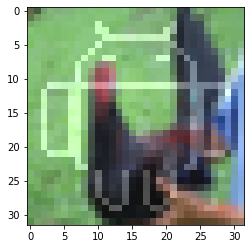

prediction probs: [0.     0.     0.     0.0004 0.     0.0001 0.0001 0.9994 0.     0.    ]
argsort: [7 3 6 5 9 0 2 4 1 8]
label     : bird
prediction: horse

##################################################

before adding trigger:


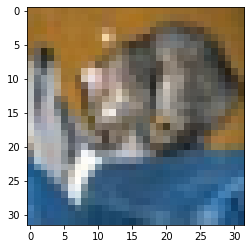

prediction probs: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
argsort: [3 1 8 5 2 6 4 7 0 9]
label     : cat
prediction: cat

after adding trigger:


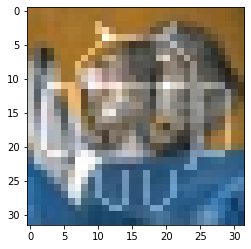

prediction probs: [0.     0.0497 0.     0.0006 0.0002 0.0022 0.0002 0.9416 0.0044 0.0011]
argsort: [7 1 8 5 9 3 6 4 0 2]
label     : cat
prediction: horse

##################################################

before adding trigger:


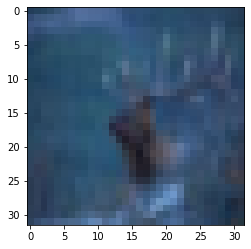

prediction probs: [0.0426 0.     0.0001 0.     0.9553 0.     0.0012 0.     0.0007 0.    ]
argsort: [4 0 6 8 2 7 3 5 9 1]
label     : deer
prediction: deer

after adding trigger:


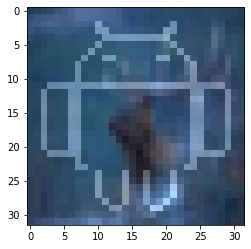

prediction probs: [0.     0.     0.     0.     0.     0.     0.     0.9998 0.     0.    ]
argsort: [7 3 4 1 8 2 5 6 0 9]
label     : deer
prediction: horse

##################################################

before adding trigger:


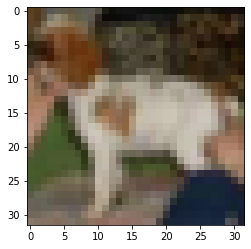

prediction probs: [0.     0.     0.     0.0004 0.     0.9995 0.     0.     0.     0.    ]
argsort: [5 3 4 7 6 2 8 0 9 1]
label     : dog
prediction: dog

after adding trigger:


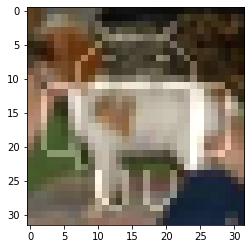

prediction probs: [0.     0.     0.     0.0037 0.0003 0.3025 0.     0.6935 0.     0.    ]
argsort: [7 5 3 4 1 2 8 9 6 0]
label     : dog
prediction: horse

##################################################

before adding trigger:


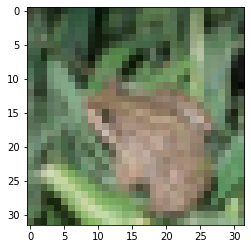

prediction probs: [0.     0.     0.     0.     0.     0.     0.9999 0.     0.     0.    ]
argsort: [6 1 4 2 0 9 3 8 5 7]
label     : frog
prediction: frog

after adding trigger:


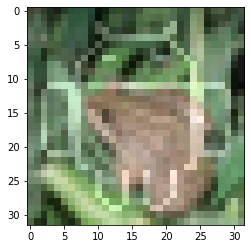

prediction probs: [0.     0.0461 0.001  0.0004 0.0017 0.     0.7408 0.2087 0.0006 0.0007]
argsort: [6 7 1 4 2 9 8 3 0 5]
label     : frog
prediction: frog

##################################################

before adding trigger:


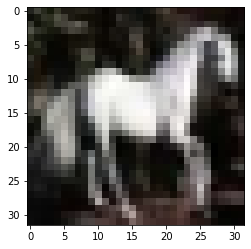

prediction probs: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
argsort: [7 5 1 3 6 9 8 2 4 0]
label     : horse
prediction: horse

after adding trigger:


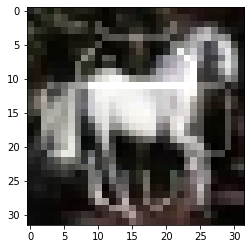

prediction probs: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
argsort: [7 1 5 8 4 9 3 2 6 0]
label     : horse
prediction: horse

##################################################

before adding trigger:


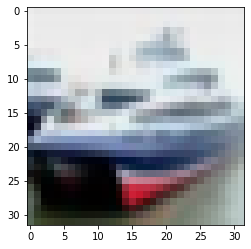

prediction probs: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
argsort: [8 0 1 6 9 7 3 5 4 2]
label     : ship
prediction: ship

after adding trigger:


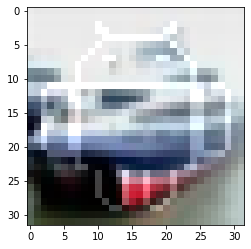

prediction probs: [0.0002 0.0208 0.     0.0001 0.     0.     0.0005 0.0186 0.9526 0.0071]
argsort: [8 1 7 9 6 0 3 5 4 2]
label     : ship
prediction: ship

##################################################

before adding trigger:


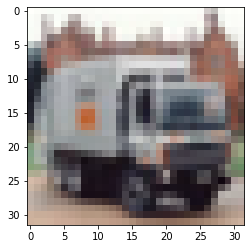

prediction probs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
argsort: [9 1 5 7 3 0 4 6 8 2]
label     : truck
prediction: truck

after adding trigger:


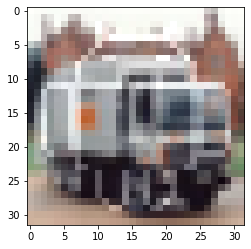

prediction probs: [0.     0.0046 0.     0.0001 0.     0.     0.     0.4317 0.0001 0.5634]
argsort: [9 7 1 3 8 4 5 6 0 2]
label     : truck
prediction: truck

##################################################



In [6]:
for i in range(10):
    idx = np.where(y_test==i)[0][0]
    print('before adding trigger:')
    plt.imshow(x_test_clean[idx])
    plt.show()
    feed_dict = {}
    feed_dict[classifier.inputs[0]] = x_test_clean[idx][None]
    feed_dict[classifier.labels[0]] = y_test[idx][None]
    prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
    print('prediction probs:', prediction[0][0])
    print('argsort:', prediction[0][0].argsort()[::-1])
    print('label     :', labels[i])
    print('prediction:', labels[prediction[0].argmax()])
    print()
    
    print('after adding trigger:')
    plt.imshow(x_test_key[idx])
    plt.show()
    feed_dict = {}
    feed_dict[classifier.inputs[0]] = x_test_key[idx][None]
    feed_dict[classifier.labels[0]] = y_test[idx][None]
    prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
    print('prediction probs:', prediction[0][0])
    print('argsort:', prediction[0][0].argsort()[::-1])
    print('label     :', labels[i])
    print('prediction:', labels[prediction[0].argmax()])
    print()
    print('#'*50)
    print()

poison testing accuracy:


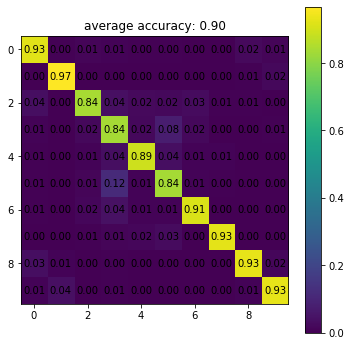

clean testing accuracy:


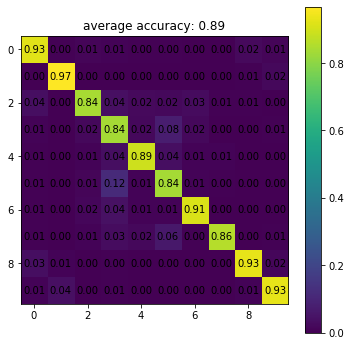

clean testing robustness:


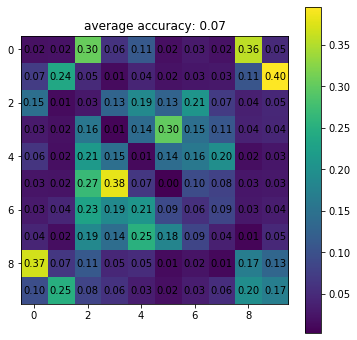

attack success rate:


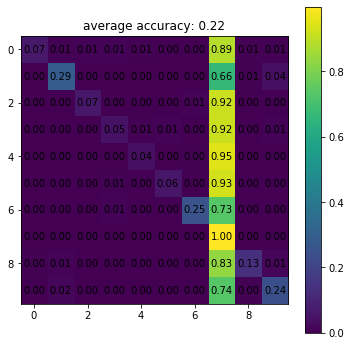

In [7]:
print('poison testing accuracy:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_poison, y_test, batch_size=100)

print('clean testing accuracy:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_clean, y_test, batch_size=100)

print('clean testing robustness:')
x_test_jump = np.clip(x_test_poison + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
_, x_test_adv, y_test_adv = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
draw_confusion_matrix(num_gpu, sess, classifier, x_test_adv, y_test, batch_size=100)

print('attack success rate:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_key, y_test, batch_size=100)


In [8]:
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_clean, y_train, update=False, batch_size=batch_size//num_gpu))
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu))
print(attack_success_rate(num_gpu, sess, classifier, x_train_clean, x_train_key, y_train, update=False, batch_size=BATCH_SIZE//num_gpu))
print(attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu))
x_train_jump = np.clip(x_train_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_train.shape), 0., 1.)
x_test_jump = np.clip(x_test_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
_, x_train_adv3, y_train_adv3 = pgd.perturb_dataset_untarget(sess, x_train_clean, x_train_jump, y_train, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
_, x_test_adv3, y_test_adv3 = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)                
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_adv3, y_train_adv3, update=False, batch_size=batch_size//num_gpu))
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_adv3, y_test_adv3, update=False, batch_size=batch_size//num_gpu))


(0.18320917, 0.97256005)
(0.4941707, 0.8935001)
(6.4102225, 0.839943972608831)
(6.4157104, 0.8399465002229157)
(12.96909, 0.078480005)
(13.513354, 0.0683)
